<a href="https://colab.research.google.com/github/mlarrarte/1marroia22/blob/master/Assignment2_DNF(FMNIST)_LarrarteMikel(2024319650).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2.2: Implementation of Deep Normalizing Flows for FMNIST Dataset
Name: MIKEL LARRARTE RODRIGUEZ

Student ID: 2024319650

Course: Advanced Topics in Machine Learning (ESW5049-41)


# Introduction

In this second notebook, I present my implementation of Deep Normalizing Flows for the second assignment of the course. In this part, we will focus on developing a model that learns to reproduce the FMNIST dataset. I will be following the steps of this tutorial:

[Tutorial 11: Normalizing Flows for image modeling](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html)

The notebook will contain code implemented following the tutorial mentioned, some visualization code to display the generated digits and a brief commentary about the performance of the implemented model. Also, to wrap everything up I will compare the results from the first notebook with the ones I get in this one.

Deep normalizing flows (DNFs) are a type of generative model that leverages normalizing flows to transform a simple, tractable distribution into a complex, high-dimensional distribution. This approach combines the strengths of variational autoencoders (VAEs) and generative adversarial networks (GANs), while addressing their limitations.

The FMNIST database (Fashion-MNIST database) is a large database of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

To start with the implementation, let's begin by loading the required modules:

In [2]:
## Standard libraries
import os
import math
import time
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. FMNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/assignment2_2"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-2-3b51d52a1064>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


In this notebook, I am going to use the pretrained models provided in the tutorial. Therefore, I will download them using the code below to the specified path above.

In [4]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial11/"
# Files to download
pretrained_files = ["MNISTFlow_simple.ckpt", "MNISTFlow_vardeq.ckpt", "MNISTFlow_multiscale.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Helping Functions

As for the MNIST dataset, to deal better with the discrete nature of the images, we transform them from a range of 0-1 to a range of 0-255 as integers.

In [6]:
# Convert images from 0-1 to 0-255 (integers)
def discretize(sample):
    return (sample * 255).to(torch.int32)

# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=False, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 177kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.19MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 19.4MB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In addition, it is recommended define a function to simplify the visualization of images/samples. Some training examples of the MNIST dataset is shown below.



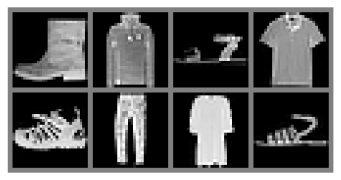

In [7]:
def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = imgs.dtype==torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype==torch.int32
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

# Normalizing Flows as generative model

In the previous assignment, we have analyzed and implemented Variational Autoencoders (VAEs) and Variational Conditional Autoencoders (VCAE) as example of generative models. However, none of them explicitly learn the probability density function
 of the real input data, as VAEs model a lower bound only. The generative model we will look at here, called Normalizing Flows, actually models the true data distribution
 and provides us with an exact likelihood estimate.

In [8]:
class ImageFlow(pl.LightningModule):

    def __init__(self, flows, import_samples=8):
        """
        Inputs:
            flows - A list of flows (each a nn.Module) that should be applied on the images.
            import_samples - Number of importance samples to use during testing (see explanation below). Can be changed at any time
        """
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.import_samples = import_samples
        # Create prior distribution for final latent space
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        # Example input for visualizing the graph
        self.example_input_array = train_set[0][0].unsqueeze(dim=0)

    def forward(self, imgs):
        # The forward function is only used for visualizing the graph
        return self._get_likelihood(imgs)

    def encode(self, imgs):
        # Given a batch of images, return the latent representation z and ldj of the transformations
        z, ldj = imgs, torch.zeros(imgs.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, imgs, return_ll=False):
        """
        Given a batch of images, return the likelihood of those.
        If return_ll is True, this function returns the log likelihood of the input.
        Otherwise, the ouptut metric is bits per dimension (scaled negative log likelihood)
        """
        z, ldj = self.encode(imgs)
        log_pz = self.prior.log_prob(z).sum(dim=[1,2,3])
        log_px = ldj + log_pz
        nll = -log_px
        # Calculating bits per dimension
        bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        return bpd.mean() if not return_ll else log_px

    @torch.no_grad()
    def sample(self, img_shape, z_init=None):
        """
        Sample a batch of images from the flow.
        """
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)

        # Transform z to x by inverting the flows
        ldj = torch.zeros(img_shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # An scheduler is optional, but can help in flows to get the last bpd improvement
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # Normalizing flows are trained by maximum likelihood => return bpd
        loss = self._get_likelihood(batch[0])
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_likelihood(batch[0])
        self.log('val_bpd', loss)

    def test_step(self, batch, batch_idx):
        # Perform importance sampling during testing => estimate likelihood M times for each image
        samples = []
        for _ in range(self.import_samples):
            img_ll = self._get_likelihood(batch[0], return_ll=True)
            samples.append(img_ll)
        img_ll = torch.stack(samples, dim=-1)

        # To average the probabilities, we need to go from log-space to exp, and back to log.
        # Logsumexp provides us a stable implementation for this
        img_ll = torch.logsumexp(img_ll, dim=-1) - np.log(self.import_samples)

        # Calculate final bpd
        bpd = -img_ll * np.log2(np.exp(1)) / np.prod(batch[0].shape[1:])
        bpd = bpd.mean()

        self.log('test_bpd', bpd)

# Dequantization

In [9]:
class Dequantization(nn.Module):

    def __init__(self, alpha=1e-5, quants=256):
        """
        Inputs:
            alpha - small constant that is used to scale the original input.
                    Prevents dealing with values very close to 0 and 1 when inverting the sigmoid
            quants - Number of possible discrete values (usually 256 for 8-bit image)
        """
        super().__init__()
        self.alpha = alpha
        self.quants = quants

    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = torch.floor(z).clamp(min=0, max=self.quants-1).to(torch.int32)
        return z, ldj

    def sigmoid(self, z, ldj, reverse=False):
        # Applies an invertible sigmoid transformation
        if not reverse:
            ldj += (-z-2*F.softplus(-z)).sum(dim=[1,2,3])
            z = torch.sigmoid(z)
            # Reversing scaling for numerical stability
            ldj -= np.log(1 - self.alpha) * np.prod(z.shape[1:])
            z = (z - 0.5 * self.alpha) / (1 - self.alpha)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha  # Scale to prevent boundaries 0 and 1
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1-z)).sum(dim=[1,2,3])
            z = torch.log(z) - torch.log(1-z)
        return z, ldj

    def dequant(self, z, ldj):
        # Transform discrete values to continuous volumes
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj

In [12]:
## Testing invertibility of dequantization layer
pl.seed_everything(42)
orig_img = train_set[0][0].unsqueeze(dim=0)
ldj = torch.zeros(1,)
dequant_module = Dequantization()
deq_img, ldj = dequant_module(orig_img, ldj, reverse=False)
reconst_img, ldj = dequant_module(deq_img, ldj, reverse=True)

d1, d2 = torch.where(orig_img.squeeze() != reconst_img.squeeze())
if len(d1) != 0:
    print("Dequantization was not invertible.")
    for i in range(d1.shape[0]):
        print("Original value:", orig_img[0,0,d1[i], d2[i]].item())
        print("Reconstructed value:", reconst_img[0,0,d1[i], d2[i]].item())
else:
    print("Successfully inverted dequantization")

INFO:lightning_fabric.utilities.seed:Seed set to 42


Successfully inverted dequantization


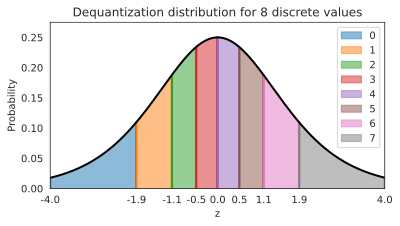

In [13]:
def visualize_dequantization(quants, prior=None):
    """
    Function for visualizing the dequantization values of discrete values in continuous space
    """
    # Prior over discrete values. If not given, a uniform is assumed
    if prior is None:
        prior = np.ones(quants, dtype=np.float32) / quants
    prior = prior / prior.sum()  # Ensure proper categorical distribution

    inp = torch.arange(-4, 4, 0.01).view(-1, 1, 1, 1) # Possible continuous values we want to consider
    ldj = torch.zeros(inp.shape[0])
    dequant_module = Dequantization(quants=quants)
    # Invert dequantization on continuous values to find corresponding discrete value
    out, ldj = dequant_module.forward(inp, ldj, reverse=True)
    inp, out, prob = inp.squeeze().numpy(), out.squeeze().numpy(), ldj.exp().numpy()
    prob = prob * prior[out] # Probability scaled by categorical prior

    # Plot volumes and continuous distribution
    sns.set_style("white")
    fig = plt.figure(figsize=(6,3))
    x_ticks = []
    for v in np.unique(out):
        indices = np.where(out==v)
        color = to_rgb(f"C{v}")
        plt.fill_between(inp[indices], prob[indices], np.zeros(indices[0].shape[0]), color=color+(0.5,), label=str(v))
        plt.plot([inp[indices[0][0]]]*2,  [0, prob[indices[0][0]]],  color=color)
        plt.plot([inp[indices[0][-1]]]*2, [0, prob[indices[0][-1]]], color=color)
        x_ticks.append(inp[indices[0][0]])
    x_ticks.append(inp.max())
    plt.xticks(x_ticks, [f"{x:.1f}" for x in x_ticks])
    plt.plot(inp,prob, color=(0.0,0.0,0.0))
    # Set final plot properties
    plt.ylim(0, prob.max()*1.1)
    plt.xlim(inp.min(), inp.max())
    plt.xlabel("z")
    plt.ylabel("Probability")
    plt.title(f"Dequantization distribution for {quants} discrete values")
    plt.legend()
    plt.show()
    plt.close()

visualize_dequantization(quants=8)

# Variational Dequantization

In [14]:
class VariationalDequantization(Dequantization):

    def __init__(self, var_flows, alpha=1e-5):
        """
        Inputs:
            var_flows - A list of flow transformations to use for modeling q(u|x)
            alpha - Small constant, see Dequantization for details
        """
        super().__init__(alpha=alpha)
        self.flows = nn.ModuleList(var_flows)

    def dequant(self, z, ldj):
        z = z.to(torch.float32)
        img = (z / 255.0) * 2 - 1 # We condition the flows on x, i.e. the original image

        # Prior of u is a uniform distribution as before
        # As most flow transformations are defined on [-infinity,+infinity], we apply an inverse sigmoid first.
        deq_noise = torch.rand_like(z).detach()
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=True)
        for flow in self.flows:
            deq_noise, ldj = flow(deq_noise, ldj, reverse=False, orig_img=img)
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=False)

        # After the flows, apply u as in standard dequantization
        z = (z + deq_noise) / 256.0
        ldj -= np.log(256.0) * np.prod(z.shape[1:])
        return z, ldj

# Coupling Layers

In [15]:
class CouplingLayer(nn.Module):

    def __init__(self, network, mask, c_in):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        # Register mask as buffer as it is a tensor which is not a parameter,
        # but should be part of the modules state.
        self.register_buffer('mask', mask)

    def forward(self, z, ldj, reverse=False, orig_img=None):
        """
        Inputs:
            z - Latent input to the flow
            ldj - The current ldj of the previous flows.
                  The ldj of this layer will be added to this tensor.
            reverse - If True, we apply the inverse of the layer.
            orig_img (optional) - Only needed in VarDeq. Allows external
                                  input to condition the flow on (e.g. original image)
        """
        # Apply network to masked input
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)

        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac

        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1,2,3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1,2,3])

        return z, ldj

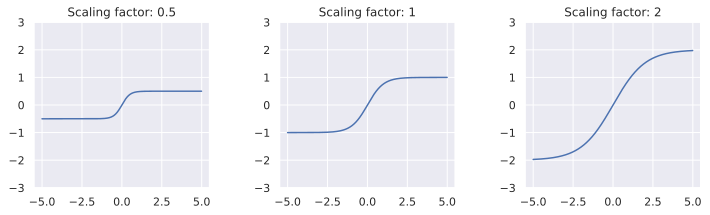

In [16]:
with torch.no_grad():
    x = torch.arange(-5,5,0.01)
    scaling_factors = [0.5, 1, 2]
    sns.set()
    fig, ax = plt.subplots(1, 3, figsize=(12,3))
    for i, scale in enumerate(scaling_factors):
        y = torch.tanh(x / scale) * scale
        ax[i].plot(x.numpy(), y.numpy())
        ax[i].set_title("Scaling factor: " + str(scale))
        ax[i].set_ylim(-3, 3)
    plt.subplots_adjust(wspace=0.4)
    sns.reset_orig()
    plt.show()

In [17]:
def create_checkerboard_mask(h, w, invert=False):
    x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    mask = torch.fmod(xx + yy, 2)
    mask = mask.to(torch.float32).view(1, 1, h, w)
    if invert:
        mask = 1 - mask
    return mask

def create_channel_mask(c_in, invert=False):
    mask = torch.cat([torch.ones(c_in//2, dtype=torch.float32),
                      torch.zeros(c_in-c_in//2, dtype=torch.float32)])
    mask = mask.view(1, c_in, 1, 1)
    if invert:
        mask = 1 - mask
    return mask

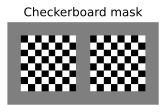

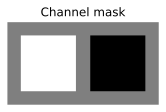

In [18]:
checkerboard_mask = create_checkerboard_mask(h=8, w=8).expand(-1,2,-1,-1)
channel_mask = create_channel_mask(c_in=2).expand(-1,-1,8,8)

show_imgs(checkerboard_mask.transpose(0,1), "Checkerboard mask")
show_imgs(channel_mask.transpose(0,1), "Channel mask")

In [19]:
class ConcatELU(nn.Module):
    """
    Activation function that applies ELU in both direction (inverted and plain).
    Allows non-linearity while providing strong gradients for any input (important for final convolution)
    """

    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)


class LayerNormChannels(nn.Module):

    def __init__(self, c_in, eps=1e-5):
        """
        This module applies layer norm across channels in an image.
        Inputs:
            c_in - Number of channels of the input
            eps - Small constant to stabilize std
        """
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.gamma + self.beta
        return y


class GatedConv(nn.Module):

    def __init__(self, c_in, c_hidden):
        """
        This module applies a two-layer convolutional ResNet block with input gate
        Inputs:
            c_in - Number of channels of the input
            c_hidden - Number of hidden dimensions we want to model (usually similar to c_in)
        """
        super().__init__()
        self.net = nn.Sequential(
            ConcatELU(),
            nn.Conv2d(2*c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1)
        )

    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)


class GatedConvNet(nn.Module):

    def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=3):
        """
        Module that summarizes the previous blocks to a full convolutional neural network.
        Inputs:
            c_in - Number of input channels
            c_hidden - Number of hidden dimensions to use within the network
            c_out - Number of output channels. If -1, 2 times the input channels are used (affine coupling)
            num_layers - Number of gated ResNet blocks to apply
        """
        super().__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        layers = []
        layers += [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [GatedConv(c_hidden, c_hidden),
                       LayerNormChannels(c_hidden)]
        layers += [ConcatELU(),
                   nn.Conv2d(2*c_hidden, c_out, kernel_size=3, padding=1)]
        self.nn = nn.Sequential(*layers)

        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()

    def forward(self, x):
        return self.nn(x)

# Training Loop

In [20]:
def create_simple_flow(use_vardeq=True):
    flow_layers = []
    if use_vardeq:
        vardeq_layers = [CouplingLayer(network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                                       mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                       c_in=1) for i in range(4)]
        flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
    else:
        flow_layers += [Dequantization()]

    for i in range(8):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32),
                                      mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                      c_in=1)]

    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

In [89]:
def train_flow(flow, model_name="MNISTFlow"):
    # Create a PyTorch Lightning trainer
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_name),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=5, # I'm going to train the models for 5 epochs, as the training process can be expensive time-wise.
                         gradient_clip_val=1.0,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=5)
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    train_data_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
    result = None

    # Check whether pretrained model exists. If yes, load it and fine-tune with the FasionMNIST dataset.
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        ckpt = torch.load(pretrained_filename, map_location=device)
        flow.load_state_dict(ckpt['state_dict'])
        print("Start fine-tuning", model_name)
        trainer.fit(flow, train_data_loader, val_loader)
    else:
      print("Start training", model_name)
      trainer.fit(flow, train_data_loader, val_loader)

    # Test best model on validation and test set if no result has been found
    # Testing can be expensive due to the importance sampling.
    if result is None:
        val_result = trainer.test(flow, val_loader, verbose=False)
        start_time = time.time()
        test_result = trainer.test(flow, test_loader, verbose=False)
        duration = time.time() - start_time
        result = {"test": test_result, "val": val_result, "time": duration / len(test_loader) / flow.import_samples}

    return flow, result

# Multi-Scale Architecture

## Squeeze and Split

In [23]:
class SqueezeFlow(nn.Module):

    def forward(self, z, ldj, reverse=False):
        B, C, H, W = z.shape
        if not reverse:
            # Forward direction: H x W x C => H/2 x W/2 x 4C
            z = z.reshape(B, C, H//2, 2, W//2, 2)
            z = z.permute(0, 1, 3, 5, 2, 4)
            z = z.reshape(B, 4*C, H//2, W//2)
        else:
            # Reverse direction: H/2 x W/2 x 4C => H x W x C
            z = z.reshape(B, C//4, 2, 2, H, W)
            z = z.permute(0, 1, 4, 2, 5, 3)
            z = z.reshape(B, C//4, H*2, W*2)
        return z, ldj

In [24]:
sq_flow = SqueezeFlow()
rand_img = torch.arange(1,17).view(1, 1, 4, 4)
print("Image (before)\n", rand_img)
forward_img, _ = sq_flow(rand_img, ldj=None, reverse=False)
print("\nImage (forward)\n", forward_img.permute(0,2,3,1)) # Permute for readability
reconst_img, _ = sq_flow(forward_img, ldj=None, reverse=True)
print("\nImage (reverse)\n", reconst_img)

Image (before)
 tensor([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [13, 14, 15, 16]]]])

Image (forward)
 tensor([[[[ 1,  2,  5,  6],
          [ 3,  4,  7,  8]],

         [[ 9, 10, 13, 14],
          [11, 12, 15, 16]]]])

Image (reverse)
 tensor([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [13, 14, 15, 16]]]])


In [25]:
class SplitFlow(nn.Module):

    def __init__(self):
        super().__init__()
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)

    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, z_split = z.chunk(2, dim=1)
            ldj += self.prior.log_prob(z_split).sum(dim=[1,2,3])
        else:
            z_split = self.prior.sample(sample_shape=z.shape).to(device)
            z = torch.cat([z, z_split], dim=1)
            ldj -= self.prior.log_prob(z_split).sum(dim=[1,2,3])
        return z, ldj

## Multi-Scale Flow

In [26]:
def create_multiscale_flow():
    flow_layers = []

    vardeq_layers = [CouplingLayer(network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                                   mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                   c_in=1) for i in range(4)]
    flow_layers += [VariationalDequantization(vardeq_layers)]

    flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32),
                                  mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                  c_in=1) for i in range(2)]
    flow_layers += [SqueezeFlow()]
    for i in range(2):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=4, c_hidden=48),
                                      mask=create_channel_mask(c_in=4, invert=(i%2==1)),
                                      c_in=4)]
    flow_layers += [SplitFlow(),
                    SqueezeFlow()]
    for i in range(4):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=8, c_hidden=64),
                                      mask=create_channel_mask(c_in=8, invert=(i%2==1)),
                                      c_in=8)]

    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

In [27]:
def print_num_params(model):
    num_params = sum([np.prod(p.shape) for p in model.parameters()])
    print("Number of parameters: {:,}".format(num_params))

print_num_params(create_simple_flow(use_vardeq=False))
print_num_params(create_simple_flow(use_vardeq=True))
print_num_params(create_multiscale_flow())

Number of parameters: 556,312
Number of parameters: 628,388
Number of parameters: 1,711,818


# Analysing the Flows

## Training Flow Variants

In this notebook, our aims is to use Normalizing Flows with the FashionMNIST dataset. Therefore, we cannot just directly use the pretrained models. That's way I decided to load the pretrained models and retrain them on the FashionMNIST dataset for 2 epochs. I know that with only 5 epochs the results we will get won't be that great but the training time increases rapidly with the number of epochs. Of course I am going to take this into account when comparing the results of this notebook with the previous notebook's results.

In [ ]:
flow_dict = {"simple": {}, "vardeq": {}, "multiscale": {}}
flow_dict["simple"]["model"], flow_dict["simple"]["result"] = train_flow(create_simple_flow(use_vardeq=False), model_name="MNISTFlow_simple")
flow_dict["vardeq"]["model"], flow_dict["vardeq"]["result"] = train_flow(create_simple_flow(use_vardeq=True), model_name="MNISTFlow_vardeq")
flow_dict["multiscale"]["model"], flow_dict["multiscale"]["result"] = train_flow(create_multiscale_flow(), model_name="MNISTFlow_multiscale")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
<ipython-input-89-96ac3a96f8ac>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for

Found pretrained model, loading...
Start fine-tuning MNISTFlow_simple


/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:1306: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Expected 6.052651405334473 but got 6.017515659332275.
Absolute difference: 0.035135746002197266 (up to 1e-05 allowed)
Relative difference: 0.005805017280729328 (up to 1e-05 allowed)
  _check_trace(


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:1306: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Expected 3.6521964073181152 but got 3.678029775619507.
Absolute difference: 0.0258333683013916 (up to 1e-05 allowed)
Relative difference: 0.007073378707023478 (up to 1e-05 allowed)
  _check_trace(


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:1306: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Expected 3.6901957988739014 but got 3.6416261196136475.
Absolute difference: 0.048569679260253906 (up to 1e-05 allowed)
Relative difference: 0.01316181631204377 (up to 1e-05 allowed)
  _check_trace(


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...
Start fine-tuning MNISTFlow_vardeq


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode  | In sizes | Out sizes
--------------------------------------------------------------------
0 | flows | ModuleList | 628 K  | train | ?        | ?        
--------------------------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.514     Total estimated model params size (MB)
327       Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:1306: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Expected 6.75172233581543 but got 6.7243146896362305.
Absolute difference: 0.02740764617919922 (up to 1e-05 allowed)
Relative difference: 0.004059356237713099 (up to 1e-05 allowed)
  _check_trace(


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [77]:
flow_dict["simple"]["result"]

{'test': [{'test_bpd': 3.4520010948181152}],
 'val': [{'test_bpd': 3.4512243270874023}],
 'time': 0.05481287267557375}

In [78]:
flow_dict["vardeq"]["result"]

{'test': [{'test_bpd': 3.3730628490448}],
 'val': [{'test_bpd': 3.3721656799316406}],
 'time': 0.06984678442311135}

In [79]:
flow_dict["multiscale"]["result"]

{'test': [{'test_bpd': 3.2447009086608887}],
 'val': [{'test_bpd': 3.2422232627868652}],
 'time': 0.04676129711661369}

## Density Modeling & Sampling

In [58]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [80]:
import tabulate
from IPython.display import display, HTML

table = [[key,
          "%4.3f bpd" % flow_dict[key]["result"]["val"][0]["test_bpd"],
          "%4.3f bpd" % flow_dict[key]["result"]["test"][0]["test_bpd"],
          "%2.0f ms" % (1000 * flow_dict[key]["result"]["time"]),
          "%2.0f ms" % (1000 * flow_dict[key]["result"].get("samp_time", 0)),
          "{:,}".format(sum([np.prod(p.shape) for p in flow_dict[key]["model"].parameters()]))]
         for key in flow_dict]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Model", "Validation Bpd", "Test Bpd", "Inference time", "Sampling time", "Num Parameters"])))

Model,Validation Bpd,Test Bpd,Inference time,Sampling time,Num Parameters
simple,3.451 bpd,3.452 bpd,55 ms,0 ms,"556,312"
vardeq,3.372 bpd,3.373 bpd,70 ms,0 ms,"628,388"
multiscale,3.242 bpd,3.245 bpd,47 ms,0 ms,"1,711,818"


## Interpolation in Latent Space


In [81]:
@torch.no_grad()
def interpolate(model, img1, img2, num_steps=8):
    """
    Inputs:
        model - object of ImageFlow class that represents the (trained) flow model
        img1, img2 - Image tensors of shape [1, 28, 28]. Images between which should be interpolated.
        num_steps - Number of interpolation steps. 8 interpolation steps mean 6 intermediate pictures besides img1 and img2
    """
    imgs = torch.stack([img1, img2], dim=0).to("cuda")
    z, _ = model.encode(imgs)
    alpha = torch.linspace(0, 1, steps=num_steps, device="cuda").view(-1, 1, 1, 1)
    interpolations = z[0:1] * alpha + z[1:2] * (1 - alpha)
    interp_imgs = model.sample(interpolations.shape[:1] + imgs.shape[1:], z_init=interpolations)
    show_imgs(interp_imgs, row_size=8)

exmp_imgs, _ = next(iter(train_loader))

In [61]:
print(flow_dict["vardeq"]["model"].device)

cpu


INFO:lightning_fabric.utilities.seed:Seed set to 42


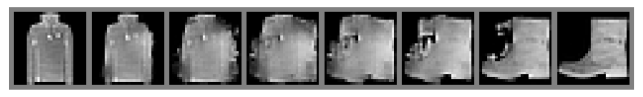

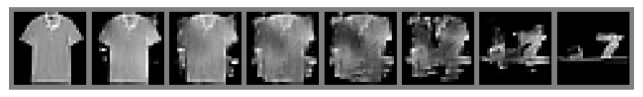

In [82]:
pl.seed_everything(42)
for i in range(2):
    interpolate(flow_dict["vardeq"]["model"].to("cuda"), exmp_imgs[2*i], exmp_imgs[2*i+1])

INFO:lightning_fabric.utilities.seed:Seed set to 42


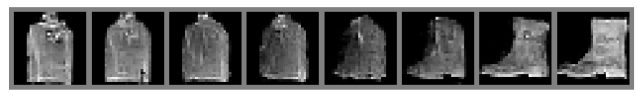

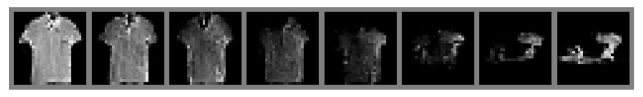

In [83]:
pl.seed_everything(42)
for i in range(2):
    interpolate(flow_dict["multiscale"]["model"].to("cuda"), exmp_imgs[2*i], exmp_imgs[2*i+1])

## Visualization of Latents in Different Levels of Multi-Scale


INFO:lightning_fabric.utilities.seed:Seed set to 44


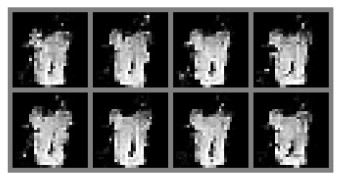

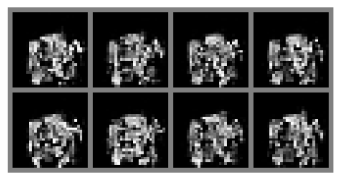

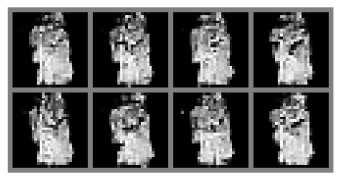

In [84]:
pl.seed_everything(44)
for _ in range(3):
    z_init = flow_dict["multiscale"]["model"].prior.sample(sample_shape=[1,8,7,7])
    z_init = z_init.expand(8, -1, -1, -1)
    samples = flow_dict["multiscale"]["model"].sample(img_shape=z_init.shape, z_init=z_init)
    show_imgs(samples.cpu())

## Visualizing Dequantization


In [65]:
def visualize_dequant_distribution(model : ImageFlow, imgs : torch.Tensor, title:str=None):
    """
    Inputs:
        model - The flow of which we want to visualize the dequantization distribution
        imgs - Example training images of which we want to visualize the dequantization distribution
    """
    imgs = imgs.to(device)
    ldj = torch.zeros(imgs.shape[0], dtype=torch.float32).to(device)
    with torch.no_grad():
        dequant_vals = []
        for _ in tqdm(range(8), leave=False):
            d, _ = model.flows[0](imgs, ldj, reverse=False)
            dequant_vals.append(d)
        dequant_vals = torch.cat(dequant_vals, dim=0)
    dequant_vals = dequant_vals.view(-1).cpu().numpy()
    sns.set()
    plt.figure(figsize=(10,3))
    plt.hist(dequant_vals, bins=256, color=to_rgb("C0")+(0.5,), edgecolor="C0", density=True)
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

sample_imgs, _ = next(iter(train_loader))

  0%|          | 0/8 [00:00<?, ?it/s]

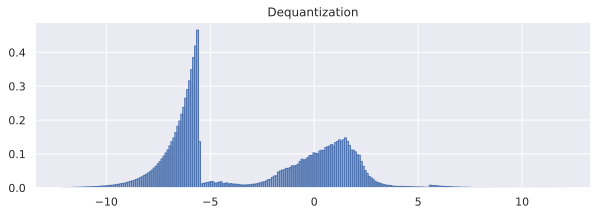

In [66]:
visualize_dequant_distribution(flow_dict["simple"]["model"], sample_imgs, title="Dequantization")

# Sampling and Visualizing Digits

This would be the end of the tutorial code. Now, I will sample and visualize digits from the three implemented model types. Beware that the defined arquitecture of the models doesn't support being conditioned, so it is not possible to condition the implemented models to generate a specific digit. That being the case, I will try to sample as many different digits as possible. After each batch of generations, I will briefly give insight about the performance of the used model in each case.

## Simple Flow Model Sampling (Standard Dequantization)

INFO:lightning_fabric.utilities.seed:Seed set to 10


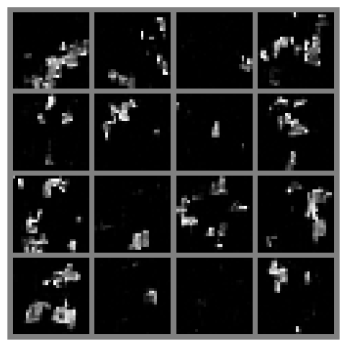

In [85]:
pl.seed_everything(10)
samples = flow_dict["simple"]["model"].to("cuda").sample(img_shape=[16,1,28,28])
show_imgs(samples.cpu())

As we can see, these are not good results. The generated "articles" cannot be categorised as any specific article as their shapes are quite abstract.

## Variational Dequantization Flow Model Sampling

INFO:lightning_fabric.utilities.seed:Seed set to 10


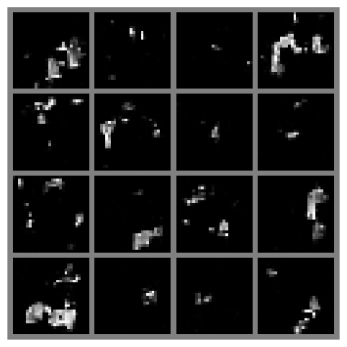

In [86]:
pl.seed_everything(10)
samples = flow_dict["vardeq"]["model"].to("cuda").sample(img_shape=[16,1,28,28])
show_imgs(samples.cpu())

In this case, these are not good results neither. The results are very similar to the ones we got with the "simple" model. In the first notebook, the second model generated images with a little more shape than the first model but in this case both of the models generate images with no recognizible shapes.

## Multiscale Flow Model Sampling

INFO:lightning_fabric.utilities.seed:Seed set to 40


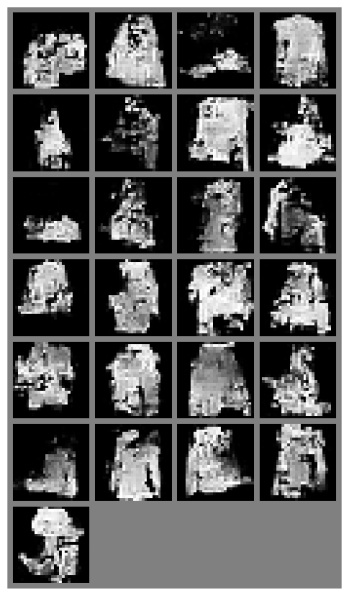

In [88]:
pl.seed_everything(40)
samples = flow_dict["multiscale"]["model"].to("cuda").sample(img_shape=[25,8,7,7])
show_imgs(samples.cpu())

With the multiscale flow model, the results are more accurate than with the other previous models. In this case, we can distinguish (maybe not very clearly) different clothing items. For example, we have some images that resemble a pullover or t-shirt. Additionally, there

In order to have an image of each article, I will now proceed to manually choose them.

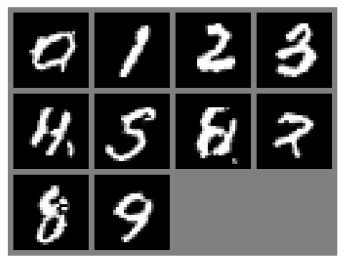

In [ ]:
generated_articles = []

# digit_0 = samples[1]
# digit_1 = samples[21]
# digit_2 = samples[12]
# digit_3 = samples[9]
# digit_4 = samples[13]
# digit_5 = samples[6]
# digit_6 = samples[17]
# digit_7 = samples[24]
# digit_8 = samples[15]
# digit_9 = samples[7]

generated_articles = [samples[1], samples[21], samples[12], samples[9], samples[13], samples[6], samples[17], samples[24], samples[15], samples[7]]

show_imgs(generated_articles)

(NOTE: Images of the numbers 6 and 7 need a little bit of imagination)

## Final discussion

As we have seen, the performance of the implemented models are not as good as we would desire. On one hand, the first two models (the one that uses standard dequantization and the one that uses variational dequantization) generated outputs of similar poor quality. Is is impossible to demonstrate that they have generated are any realistic digits. On the other hand, the multiscale model has been able to generate at least number-looking shapes. In the images I have manually chosen for example, almost every digit is recognizable by a human without any additional context (except the numbers 6, 7 and maybe 4).

To improve the performance of the models, I would mainly suggest adding more coupling layers so the model is able to learn more details. However, this could noticeable impact the computational cost overall. Another idea I had is to use different transformations instead of the affine transformations. These transformations maybe are not the most suitable for implementing normalizing flows. After a little research I found out nowadays there are researchs being conducted about this so I think this aspect might be key to improve the overall performance of normalizing flows.

With this, I conclude the first part of the second assignment. Thanks for reading!!!